Ref: https://www.tensorflow.org/text/tutorials/nmt_with_attention#export

In [1]:
!pip install tensorflow-text sacrebleu evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.2 MB/s eta 0:00:00


In [2]:
## Data
!wget https://github.com/alexa/alexa-point-of-view-dataset/raw/main/data/train.tsv
!wget https://github.com/alexa/alexa-point-of-view-dataset/raw/main/data/test.tsv
!wget https://github.com/alexa/alexa-point-of-view-dataset/raw/main/data/dev.tsv
!wget https://github.com/alexa/alexa-point-of-view-dataset/raw/main/data/total.tsv

--2023-11-02 22:44:20--  https://github.com/alexa/alexa-point-of-view-dataset/raw/main/data/train.tsv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexa/alexa-point-of-view-dataset/main/data/train.tsv [following]
--2023-11-02 22:44:21--  https://raw.githubusercontent.com/alexa/alexa-point-of-view-dataset/main/data/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3341471 (3.2M) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]   3.19M  --.-KB/s    in 0.02s   

2023-11-02 22:44:21 (183 MB/s) - ‘train.tsv’ saved [3341471/3341471]

--2023-11-02 22:44

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
import pathlib

In [4]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [5]:
target_raw, context_raw = load_data(pathlib.Path("/content/train.tsv"))
context_raw[-1], target_raw[-1]

('@SCN@ is wondering why the toilet seat was left up.',
 'please ask @CN@ why was the toilet seat was left up.')

In [6]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))


In [7]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break


tf.Tensor(
[b'@SCN@ asks do you feel appetite?'
 b'hi @CN@, @SCN@ says that they have submitted the documentation'
 b'hi @CN@ , @SCN@ conveys that the sessions are tough'
 b'hi @CN@, @SCN@ reminds you to get a bass guitarist for the band'
 b'hi @CN@ , @SCN@ requests you for an invitation to join the gaming club'], shape=(5,), dtype=string)

tf.Tensor(
[b'ask @CN@ do you feel appetite?'
 b'tell @CN@ that the i have submitted the documentation'
 b'can you tell @CN@ that the sessions are tough'
 b'can you remind @CN@ to get a bass guitarist for the band'
 b'ask @CN@ to send an invitation to join the gaming club'], shape=(5,), dtype=string)


Standardization

In [8]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


In [9]:
example_text = tf.constant("hi @CN@ , @SCN@ wanted you to read the catalog.")
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

hi @CN@ , @SCN@ wanted you to read the catalog.
[START] hi cn  ,  scn wanted you to read the catalog . [END]


Text Vectorization

In [10]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)


In [11]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'scn', '[START]', '[END]', 'cn', ',', 'to', 'you', 'hi']

In [12]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'cn', 'ask', 'you', 'the', 'to', ',']

In [13]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[3, 2, 31, 34, 8, 627, 1, 21, 4],
 [3, 9, 5, 6, 2, 32, 20, 36, 35, 1122, 10, 2543, 4],
 [3, 9, 5, 6, 2, 98, 20, 10, 1874, 25, 3200, 4]]>

In [14]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)


'[START] scn asks do you feel [UNK] ? [END]'

Text(0.5, 1.0, 'Mask')

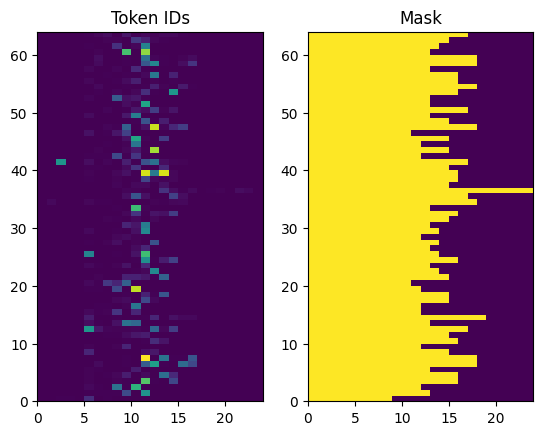

In [15]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')


Process the dataset

In [16]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)


In [17]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())


[  3   9   5   6   2  16   7 181  26  57]

[  2   5   4  18  54 311   0   0   0   0]
[  5   4  18  54 311   3   0   0   0   0]


Eoncoder Decoder

In [18]:
UNITS = 256

In [19]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context


In [20]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')


Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


In [21]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)


    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x


In [22]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')


Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 18, 256)
Attention result, shape (batch, t, units): (64, 18, 256)
Attention weights, shape (batch, t, s):    (64, 18, 22)


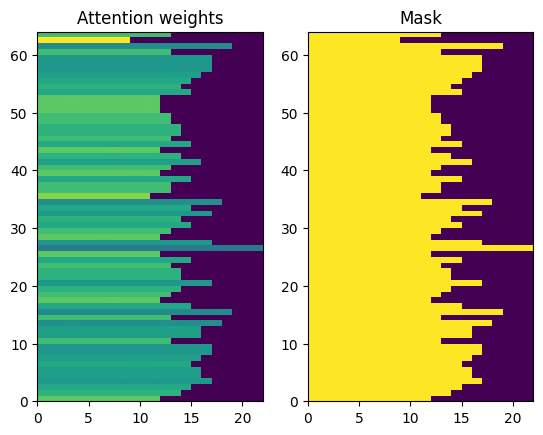

In [23]:
# Attention weights across the context sequences at t=0
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [24]:
# Decoder
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)


In [25]:
## Training
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):

  # 1. Lookup the embeddings
  x = self.embedding(x)

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)

  if return_state:
    return logits, state
  else:
    return logits


In [26]:
decoder = Decoder(target_text_processor, UNITS)

In [27]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')


encoder output shape: (batch, s, units) (64, 22, 256)
input target tokens shape: (batch, t) (64, 18)
logits shape shape: (batch, target_vocabulary_size) (64, 18, 5000)


### Inference utility

In [28]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]


In [29]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result


In [30]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state


In [31]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()


array([b'hit cus granny training visited reporter eagle item president mba',
       b'quit grounds d deals talk english mustache ide diet richard',
       b'r denmark type nearest disco press meds question according submit'],
      dtype=object)

### Model

In [32]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits


In [33]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')


Context tokens, shape: (batch, s, units) (64, 22)
Target tokens, shape: (batch, t) (64, 18)
logits, shape: (batch, t, target_vocabulary_size) (64, 18, 5000)


In [34]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)


In [35]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [36]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])


In [37]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}


{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [38]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 11s 28ms/step - loss: 8.5275 - masked_acc: 1.5457e-04 - masked_loss: 8.5275


{'loss': 8.527454376220703,
 'masked_acc': 0.0001545698323752731,
 'masked_loss': 8.527454376220703}

In [39]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])


Epoch 1/100
100/100 [==============================] - 30s 151ms/step - loss: 4.0937 - masked_acc: 0.3847 - masked_loss: 4.0937 - val_loss: 2.9806 - val_masked_acc: 0.5143 - val_masked_loss: 2.9806
Epoch 2/100
100/100 [==============================] - 5s 51ms/step - loss: 2.6477 - masked_acc: 0.5633 - masked_loss: 2.6477 - val_loss: 2.0818 - val_masked_acc: 0.6375 - val_masked_loss: 2.0818
Epoch 3/100
100/100 [==============================] - 6s 56ms/step - loss: 1.8024 - masked_acc: 0.6819 - masked_loss: 1.8024 - val_loss: 1.4139 - val_masked_acc: 0.7390 - val_masked_loss: 1.4139
Epoch 4/100
100/100 [==============================] - 4s 45ms/step - loss: 1.2968 - masked_acc: 0.7581 - masked_loss: 1.2968 - val_loss: 1.0470 - val_masked_acc: 0.7972 - val_masked_loss: 1.0470
Epoch 5/100
100/100 [==============================] - 4s 41ms/step - loss: 0.9423 - masked_acc: 0.8114 - masked_loss: 0.9405 - val_loss: 0.8342 - val_masked_acc: 0.8288 - val_masked_loss: 0.8342
Epoch 6/100
100/10

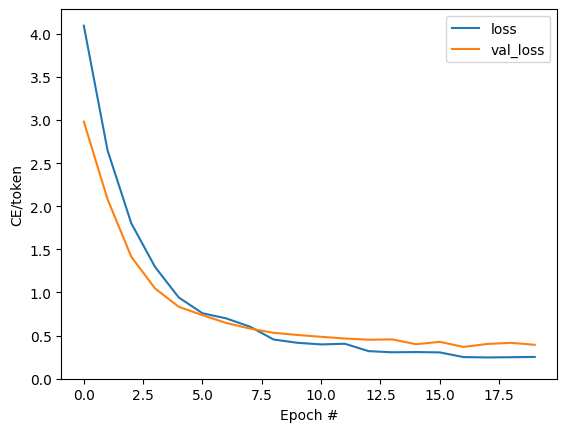

In [40]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()


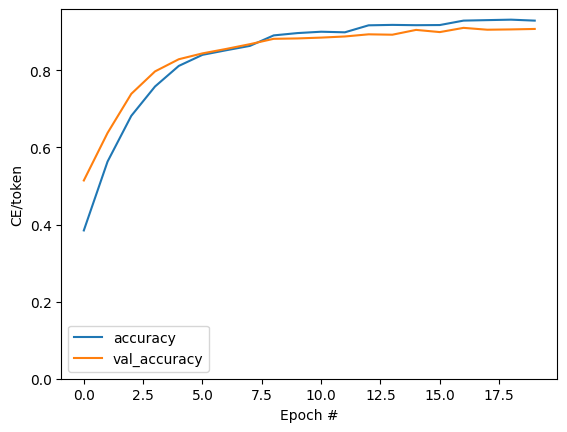

In [41]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()


In [42]:
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  # tokens = einops.rearrange(tokens, 't batch 1 -> batch t')

  text = self.decoder.tokens_to_text(tokens)

  return text


In [43]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')


In [44]:
inputs = ['hi @CN@ , @SCN@ wanted you to read the catalog.',
 'hi @CN@ , @SCN@ is eager to know how to play a proper cover drive',
 'hi @CN@, @SCN@ is asking what punishment would you give someone who is on welfare illegally?',
 'hi @CN@, @SCN@ wants to inform you to pick up the groceries.',
 'hi @CN@ , @SCN@ is informing that the reviews are really poor'
]


In [56]:
%%time
for t in inputs:
  print("Original", t)
  decoded = [text[0].decode() for text in model.translate([t]).numpy()]
  print("Translated", " ".join(decoded))
  print()


Original hi @CN@ , @SCN@ wanted you to read the catalog.
Translated can you ask cn to read the catalog 

Original hi @CN@ , @SCN@ is eager to know how to play a proper cover drive
Translated can you ask cn how to play a proper cover drive 

Original hi @CN@, @SCN@ is asking what punishment would you give someone who is on welfare illegally?
Translated ask cn , what punishment would you give someone who is on welfare ? 

Original hi @CN@, @SCN@ wants to inform you to pick up the groceries.
Translated please ask cn to pick up the groceries 

Original hi @CN@ , @SCN@ is informing that the reviews are really poor
Translated can you tell cn that the reviews are really poor 

CPU times: user 2.61 s, sys: 22.4 ms, total: 2.63 s
Wall time: 4.62 s


In [47]:
# model.plot_attention(inputs[2])

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

In [ ]:
%%time
result = export.translate(inputs)

print(result[0].numpy())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup